<a href="https://colab.research.google.com/github/LisethTiria/Biosenales-2025-1/blob/main/practica_3_parte_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# %%
# Esta celda importa las librerías necesarias para el análisis de datos,
# visualización, procesamiento de señales y pruebas estadísticas.
import numpy as np  # Librería fundamental para cálculos numéricos
import pandas as pd  # Librería para manipulación y análisis de datos
import matplotlib.pyplot as plt  # Librería para graficar y visualizar datos
import scipy.io as sio  # Operaciones de entrada/salida, especialmente para archivos .mat
import scipy.signal  # Herramientas de procesamiento de señales
from scipy.signal import find_peaks  # Función para la detección de picos
from scipy import signal # Procesamiento de señales
from scipy.stats import levene, ttest_ind, mannwhitneyu, shapiro  # Pruebas estadísticas
from google.colab import drive  # Específico de Google Colab, para montar Google Drive

In [ ]:
# %%
def calcular_rms(x):
    """
    Calcula el valor cuadrático medio (RMS) de una señal x.

    Parámetros:
        x (list o np.array): Señal discreta, una lista o arreglo de N muestras.

    Retorna:
        float: Valor RMS de la señal.
    """
    x = np.array(x)  # Asegura que sea un arreglo de NumPy
    N = len(x)
    rms = np.sqrt(np.sum(x**2) / N)
    return rms

In [ ]:
# %%
# Esta celda monta Google Drive para acceder a los archivos de datos y luego
# carga el archivo 'signals.mat' que contiene los datos del ECG.
drive.mount('/content/drive')  # Monta Google Drive

# Carga el archivo .mat
try:
  mat_data = sio.loadmat('/content/Biosenales/signals.mat') # Reemplaza con la ruta correcta en tu Google Drive
except FileNotFoundError:
  print("Error: 'signals.mat' no encontrado. Por favor, verifica la ruta del archivo.")
  exit()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

Fm=1024  # Frecuencia de muestreo en Hz
duracion = 30         # Duración de la señal en segundos
N = Fm * duracion     # Número total de muestras

t = np.linspace(0, duracion, N, endpoint=False)  # Vector de tiempo
print(t)

[0.00000000e+00 9.76562500e-04 1.95312500e-03 ... 2.99970703e+01
 2.99980469e+01 2.99990234e+01]


In [ ]:
# abrir archivo signals.mat
mat_data = sio.loadmat('/content/Biosenales/signals.mat')
# cargar señales
ECG_asRecording = mat_data['ECG_asRecording'][0]
ECG_filtered = mat_data['ECG_filtered'][0]


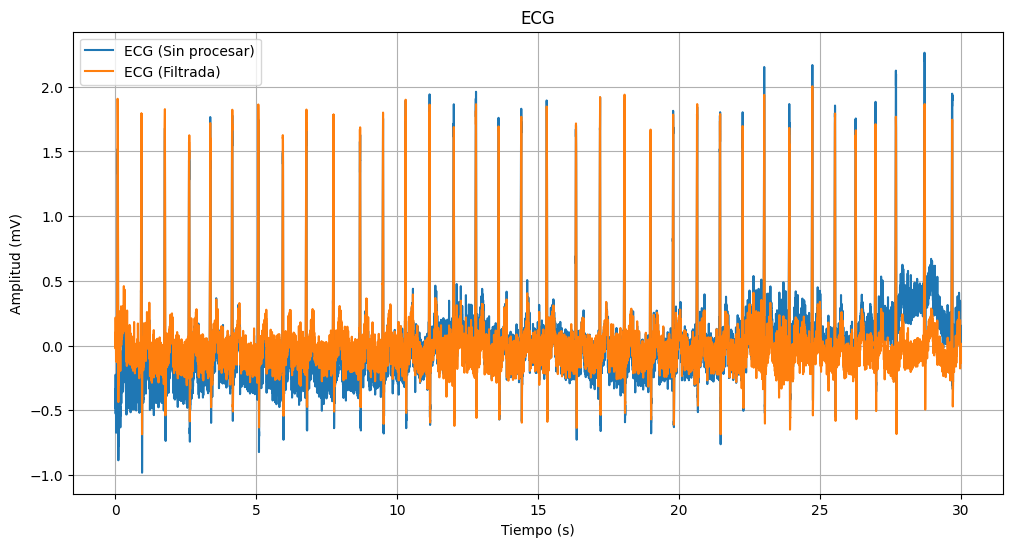

In [ ]:
# %%
# Esta celda grafica las señales de ECG sin procesar y filtrada a lo largo del tiempo.
# También elimina la desviación de la señal de ECG sin procesar.

# Asumiendo que ECG_asRecording y ECG_filtered están en mat_data
ECG_asRecording = mat_data['ECG_asRecording'][0]
ECG_filtered = mat_data['ECG_filtered'][0]

# Eliminar la desviación de ECG_asRecording
ECG_asRecording = ECG_asRecording - np.mean(ECG_asRecording)

# Graficar las señales
plt.figure(figsize=(12, 6))
plt.plot(t, ECG_asRecording/1000, label='ECG (Sin procesar)')
plt.plot(t, ECG_filtered/1000, label='ECG (Filtrada)')

plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud (mV)')
plt.title('ECG')
plt.legend()
plt.grid(True)
plt.show()

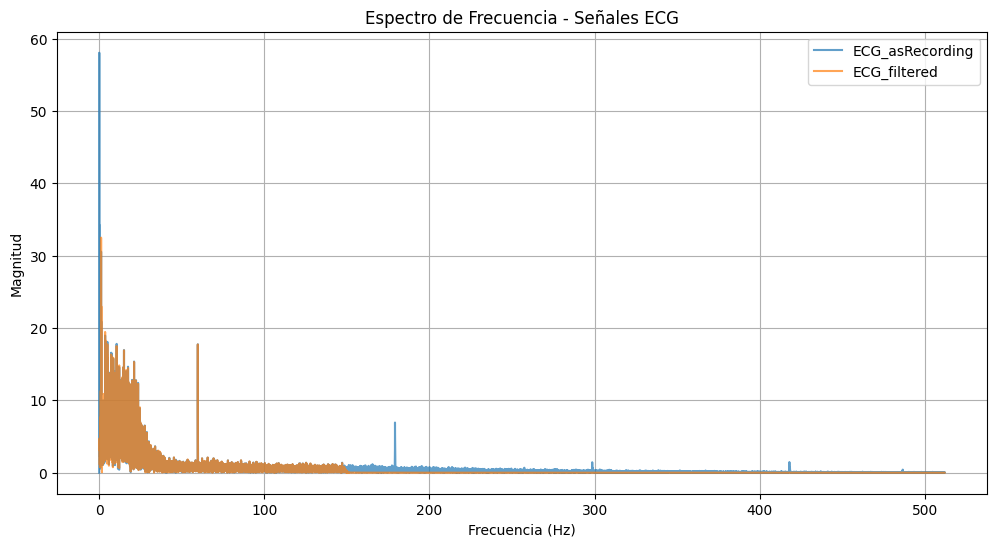

In [ ]:
# Cálculo de la FFT
fft_asRecording = np.fft.fft(ECG_asRecording)
fft_filtered = np.fft.fft(ECG_filtered)

# Vector de frecuencias
frecuencias = np.fft.fftfreq(N, 1/Fm)

# Magnitud normalizada
magnitude_asRecording = np.abs(fft_asRecording) / N
magnitude_filtered = np.abs(fft_filtered) / N

# Solo usar la mitad positiva
half = N // 2
frecuencias = frecuencias[:half]
magnitude_asRecording = magnitude_asRecording[:half]
magnitude_filtered = magnitude_filtered[:half]

# Graficar el espectro
plt.figure(figsize=(12, 6))
plt.plot(frecuencias, magnitude_asRecording, label='ECG_asRecording', alpha=0.7)
plt.plot(frecuencias, magnitude_filtered, label='ECG_filtered', alpha=0.7)

plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Magnitud')
plt.title('Espectro de Frecuencia - Señales ECG')
plt.legend()
plt.grid(True)
plt.show()


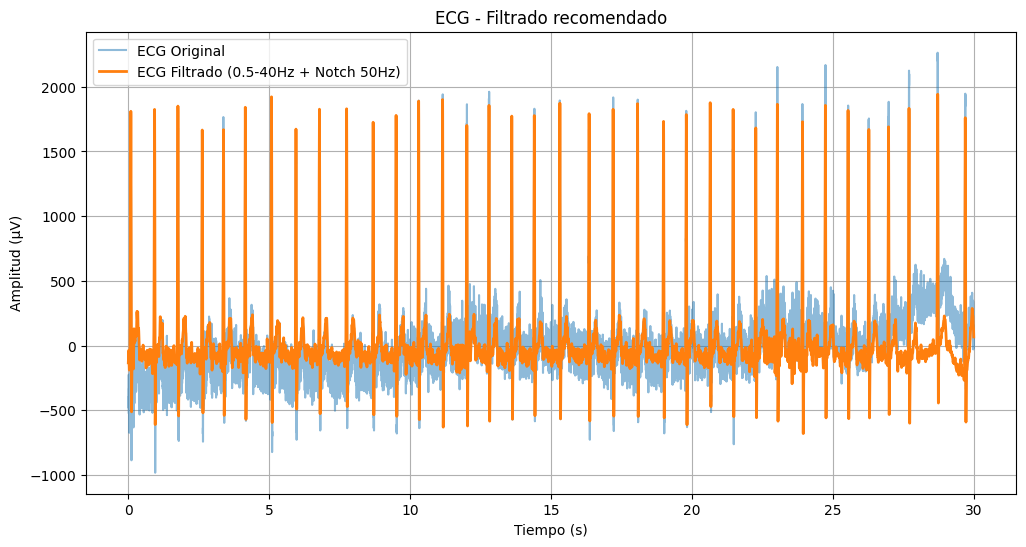

In [ ]:
from scipy.signal import butter, filtfilt, iirnotch

# Datos
Fm = 1024  # Frecuencia de muestreo en Hz

# === 1️⃣ Filtro Pasa-Banda Butterworth (0.5 - 40 Hz) ===

def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs  # Frecuencia de Nyquist
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

# Crear el filtro
b_band, a_band = butter_bandpass(0.5, 40, Fm, order=4)

# Aplicar el filtro pasa banda
ECG_bandpassed = filtfilt(b_band, a_band, ECG_asRecording)

# === 2️⃣ Filtro Notch para eliminar 50Hz ===

def apply_notch(data, f0=50.0, Q=30.0, fs=1024):
    b_notch, a_notch = iirnotch(f0, Q, fs)
    filtered = filtfilt(b_notch, a_notch, data)
    return filtered

# Aplicar filtro notch
ECG_final = apply_notch(ECG_bandpassed)

# === 3️⃣ Graficar Resultado ===

import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(t, ECG_asRecording, label='ECG Original', alpha=0.5)
plt.plot(t, ECG_final, label='ECG Filtrado (0.5-40Hz + Notch 50Hz)', linewidth=2)
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud (µV)')
plt.title('ECG - Filtrado recomendado')
plt.legend()
plt.grid(True)
plt.show()


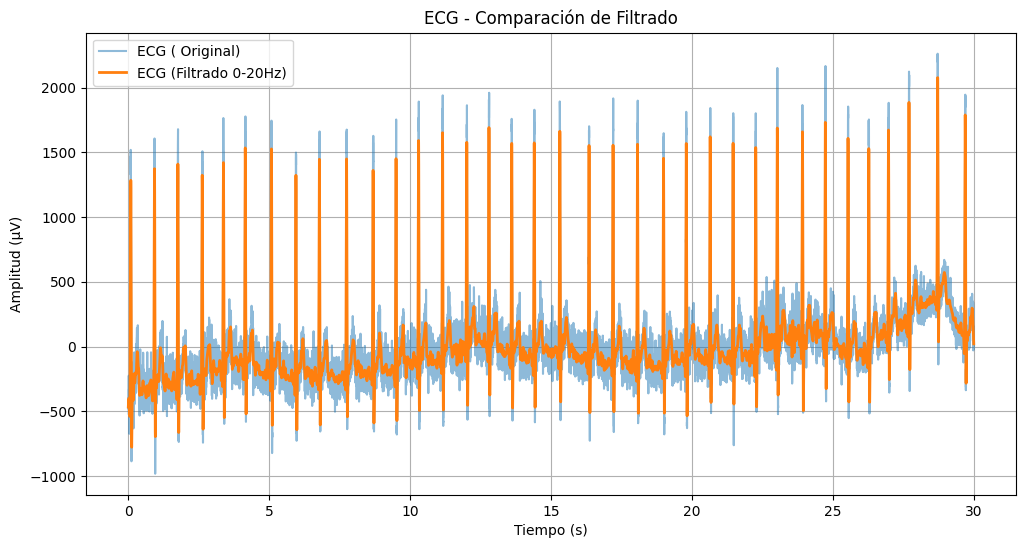

In [ ]:
from scipy.signal import butter, filtfilt

# Crear filtro pasa-bajo
def butter_lowpass(cutoff, fs, order=4):
    nyq = 0.5 * fs  # Frecuencia de Nyquist
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

# Aplicar filtro
def aplicar_filtro(data, cutoff, fs, order=4):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Parámetros del filtro
cutoff = 25  # Frecuencia de corte en Hz
order = 4    # Orden del filtro

# Filtrar la señal
ECG_filtered_20Hz = aplicar_filtro(ECG_asRecording, cutoff, Fm, order)

# Graficar la señal filtrada
plt.figure(figsize=(12, 6))
plt.plot(t, ECG_asRecording, label='ECG ( Original)', alpha=0.5)
plt.plot(t, ECG_filtered_20Hz, label='ECG (Filtrado 0-20Hz)', linewidth=2)
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud (µV)')
plt.title('ECG - Comparación de Filtrado')
plt.legend()
plt.grid(True)
plt.show()


Media: -218.57046559341515
RMS: 426.14710554672087
Varianza: 133828.30713612578
Desviación estándar: 365.82551460515407


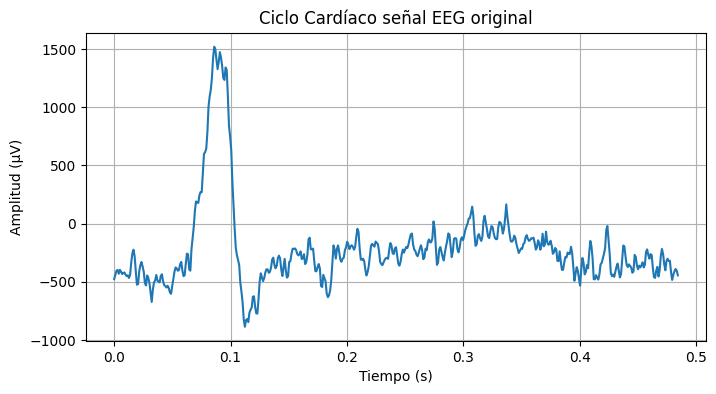

In [ ]:
# %%
# Esta celda selecciona un solo ciclo cardíaco (0.8 segundos) del ECG sin procesar,
# lo grafica y calcula estadísticas básicas (media, RMS, varianza, desviación estándar).

# Encuentra los picos R (es posible que deba ajustar el umbral y otros parámetros)
# Este es un ejemplo simplificado y puede que no sea preciso para todas las señales de ECG
peaks, _ = scipy.signal.find_peaks(ECG_asRecording, height=0.8, distance=150) # Ajustar altura y distancia

# Selecciona un ciclo cardíaco (0.8 segundos) alrededor del primer pico
if len(peaks)>0:
  peak_index = peaks[0]  # Índice del primer pico
  cycle_start = int(max(0, peak_index - 0.4 * Fm)) # inicio del ciclo
  cycle_end = int(min(len(ECG_asRecording), peak_index + 0.4 * Fm)) # fin del ciclo
  heart_cycle = ECG_asRecording[cycle_start:cycle_end]
  time_cycle = t[cycle_start:cycle_end]


  # Calcula estadísticas
  mean_cycle = np.mean(heart_cycle)
  rms_cycle = calcular_rms(heart_cycle)
  variance_cycle = np.var(heart_cycle)
  std_dev_cycle = np.std(heart_cycle)

  # Imprime los resultados
  print("Media:", mean_cycle)
  print("RMS:", rms_cycle)
  print("Varianza:", variance_cycle)
  print("Desviación estándar:", std_dev_cycle)

  # Grafica el ciclo cardíaco seleccionado
  plt.figure(figsize=(8, 4))
  plt.plot(time_cycle, heart_cycle)
  plt.xlabel('Tiempo (s)')
  plt.ylabel('Amplitud (µV)')
  plt.title('Ciclo Cardíaco señal EEG original')
  plt.grid(True)
  plt.show()
else:
    print("No se encontraron picos en la señal de ECG.")

Media: 180.26784772961588
RMS: 411.82258932182935
Varianza: 137101.34815066817
Desviación estándar: 370.2719921229098


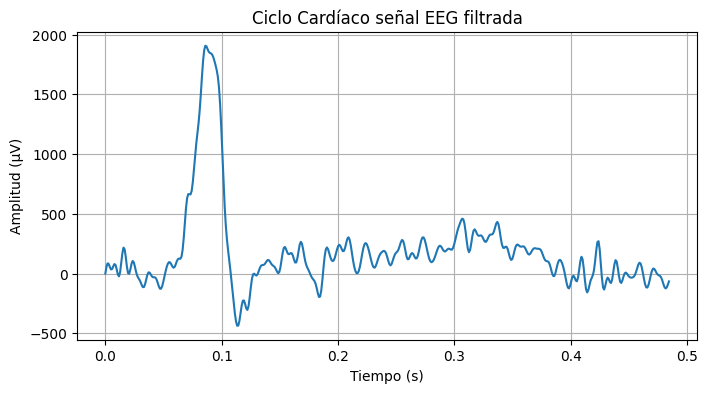

In [ ]:
# %%
# Esta celda es similar a la anterior, pero analiza un ciclo cardíaco
# de la señal de ECG filtrada en lugar de la señal sin procesar.
peaks, _ = scipy.signal.find_peaks(ECG_filtered, height=0.8, distance=150) # Ajustar altura y distancia

# Selecciona un ciclo cardíaco (0.8 segundos) alrededor del primer pico
if len(peaks)>0:
  peak_index_f = peaks[0]  # Índice del primer pico
  cycle_start_f = int(max(0, peak_index_f - 0.4 * Fm)) # inicio del ciclo
  cycle_end_f = int(min(len(ECG_filtered), peak_index_f + 0.4 * Fm)) # fin del ciclo
  heart_cycle_f = ECG_filtered[cycle_start_f:cycle_end_f]
  time_cycle_f = t[cycle_start_f:cycle_end_f]


  # Calcula estadísticas
  mean_cycle_f = np.mean(heart_cycle_f)
  rms_cycle_f = calcular_rms(heart_cycle_f)
  variance_cycle_f = np.var(heart_cycle_f)
  std_dev_cycle_f = np.std(heart_cycle_f)

  # Imprime los resultados
  print("Media:", mean_cycle_f)
  print("RMS:", rms_cycle_f)
  print("Varianza:", variance_cycle_f)
  print("Desviación estándar:", std_dev_cycle_f)

  # Grafica el ciclo cardíaco seleccionado
  plt.figure(figsize=(8, 4))
  plt.plot(time_cycle_f, heart_cycle_f)
  plt.xlabel('Tiempo (s)')
  plt.ylabel('Amplitud (µV)')
  plt.title('Ciclo Cardíaco señal EEG filtrada')
  plt.grid(True)
  plt.show()
else:
    print("No se encontraron picos en la señal de ECG.")

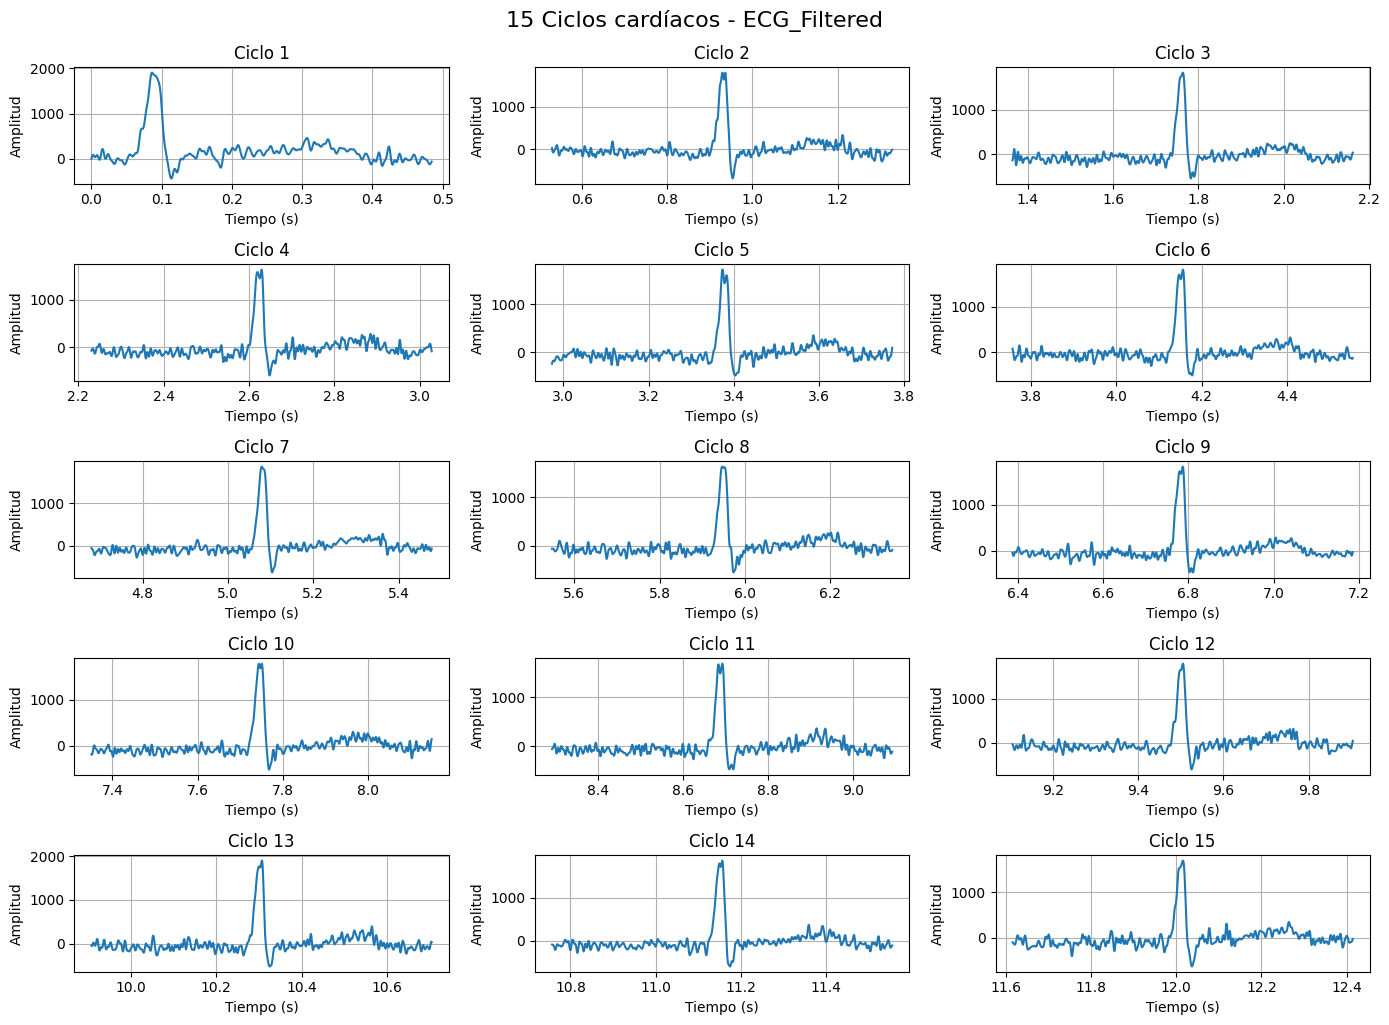

    Ciclo    Promedio         RMS       Varianza  Desviación estándar
0       1  180.267848  411.822589  137101.348151           370.271992
1       2    8.432600  297.267163   88296.657260           297.147535
2       3   -8.622884  295.178003   87055.699228           295.052028
3       4  -14.014065  278.849923   77560.885480           278.497550
4       5    9.954976  280.637101   78658.081106           280.460480
5       6   12.067757  295.908014   87415.921773           295.661837
6       7   -0.319505  303.038714   91832.359841           303.038545
7       8   -0.878497  274.668943   75442.256680           274.667538
8       9   13.020998  293.414340   85922.428758           293.125278
9      10   13.447980  293.358343   85878.269433           293.049944
10     11   -1.285988  278.690339   77666.651059           278.687372
11     12   -4.810197  289.338566   83693.667687           289.298579
12     13   16.031719  303.007010   91556.232064           302.582604
13     14   -9.80038

In [ ]:
# %%
# Esta celda analiza 15 ciclos cardíacos de la señal de ECG filtrada.
# Calcula estadísticas para cada ciclo y los grafica individualmente.
duracion_ciclo = int(0.8 * Fm)
mitad_ciclo = duracion_ciclo // 2

# Detectar picos R
peaks, _ = scipy.signal.find_peaks(ECG_filtered, height=0.8, distance=int(0.6 * Fm))

# Asegurar que hay al menos 15 picos
if len(peaks) >= 15:
    resultados = []
    plt.figure(figsize=(14, 10))

    for i in range(15):
        peak_index = peaks[i]
        inicio = max(0, peak_index - mitad_ciclo)
        fin = min(len(ECG_filtered), peak_index + mitad_ciclo)
        ciclo = ECG_filtered[inicio:fin]
        tiempo = t[inicio:fin]

        # Estadísticas
        promedio = np.mean(ciclo)
        rms = np.sqrt(np.mean(ciclo ** 2))
        varianza = np.var(ciclo)
        std_dev = np.std(ciclo)

        resultados.append({
            'Ciclo': i + 1,
            'Promedio': promedio,
            'RMS': rms,
            'Varianza': varianza,
            'Desviación estándar': std_dev
        })

        # Graficar ciclo
        plt.subplot(5, 3, i + 1)
        plt.plot(tiempo, ciclo)
        plt.title(f'Ciclo {i+1}')
        plt.xlabel('Tiempo (s)')
        plt.ylabel('Amplitud')
        plt.grid(True)

    plt.tight_layout()
    plt.suptitle("15 Ciclos cardíacos - ECG_Filtered", fontsize=16, y=1.02)
    plt.show()

    # Mostrar resultados en tabla
    df_resultados = pd.DataFrame(resultados)
    print(df_resultados)

else:
    print("No se encontraron suficientes picos R para analizar 15 ciclos.")

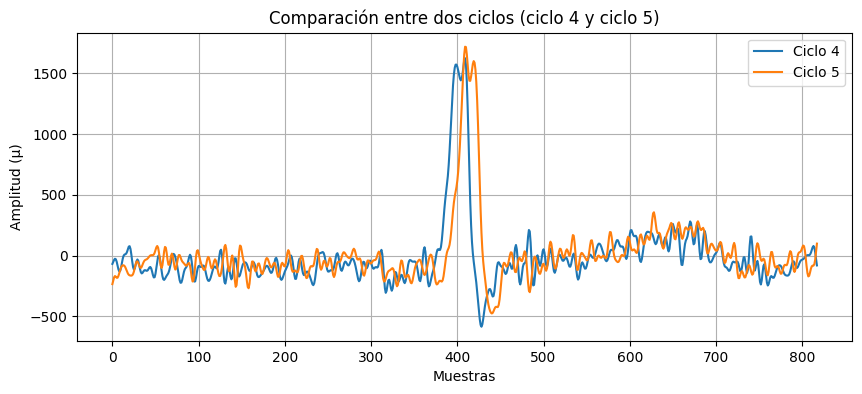


--- Supuestos ---
Normalidad ciclo 4 (p=0.00000000) No normal
Normalidad ciclo 5 (p=0.00000000)  No normal
Homocedasticidad (Levene) (p=0.84454827) Varianzas iguales

--- Prueba estadística ---
Prueba U de Mann-Whitney (p=0.00006349) Diferencia significativa

--- Prueba de Dickey-Fuller para estacionariedad global ---
Estadístico ADF: -24.13410675
Valor p: 0.00000000
 La señal es estacionaria


In [ ]:
# %%
# Esta celda compara dos ciclos cardíacos específicos
# y realiza pruebas estadísticas para evaluar su similitud.
# También prueba la estacionariedad de la señal de ECG general.
import numpy as np
import scipy.io
import scipy.signal
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import shapiro, levene, ttest_ind, mannwhitneyu
from statsmodels.tsa.stattools import adfuller

# Cargar datos
mat = scipy.io.loadmat('/content/Biosenales/signals.mat')
ECG = mat['ECG_filtered'].flatten()

# Parámetros
Fm = 1024  # Frecuencia de muestreo
t = np.arange(len(ECG)) / Fm
duracion_ciclo = int(0.8 * Fm)
mitad_ciclo = duracion_ciclo // 2

# Detectar picos R
peaks, _ = scipy.signal.find_peaks(ECG, height=0.8, distance=int(0.6 * Fm))

# Asegurarse que hay suficientes picos
if len(peaks) >= 5:
    # Seleccionar dos picos específicos (no aleatorios)
    peak1, peak2 = peaks[3], peaks[4]  # Por ejemplo, el tercero y el cuarto

    ciclo1 = ECG[max(0, peak1 - mitad_ciclo):peak1 + mitad_ciclo]
    ciclo2 = ECG[max(0, peak2 - mitad_ciclo):peak2 + mitad_ciclo]

    # Graficar los ciclos
    plt.figure(figsize=(10, 4))
    plt.plot(ciclo1, label='Ciclo 4')
    plt.plot(ciclo2, label='Ciclo 5')
    plt.title("Comparación entre dos ciclos (ciclo 4 y ciclo 5)")
    plt.xlabel("Muestras")
    plt.ylabel("Amplitud (μ)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Verificación de supuestos
    print("\n--- Supuestos ---")

    # Normalidad
    stat1, p1 = shapiro(ciclo1)
    stat2, p2 = shapiro(ciclo2)
    print(f"Normalidad ciclo 4 (p={p1:.8f}) {' Normal' if p1 > 0.05 else 'No normal'}")
    print(f"Normalidad ciclo 5 (p={p2:.8f}) {' Normal' if p2 > 0.05 else ' No normal'}")

    # Homocedasticidad
    stat_lev, p_lev = levene(ciclo1, ciclo2)
    print(f"Homocedasticidad (Levene) (p={p_lev:.8f}) {'Varianzas iguales' if p_lev > 0.05 else ' Varianzas diferentes'}")

    # Prueba t o prueba U
    print("\n--- Prueba estadística ---")
    if p1 > 0.05 and p2 > 0.05 and p_lev > 0.05:
        stat_t, p_t = ttest_ind(ciclo1, ciclo2)
        print(f"Prueba t (p={p_t:.8f}) {' Diferencia significativa' if p_t < 0.05 else ' No hay diferencia'}")
    else:
        stat_u, p_u = mannwhitneyu(ciclo1, ciclo2)
        print(f"Prueba U de Mann-Whitney (p={p_u:.8f}) {'Diferencia significativa' if p_u < 0.05 else 'No hay diferencia'}")

    # Estacionariedad global con prueba Dickey-Fuller
    print("\n--- Prueba de Dickey-Fuller para estacionariedad global ---")
    adf_stat, p_adf, _, _, _, _ = adfuller(ECG)
    print(f"Estadístico ADF: {adf_stat:.8f}")
    print(f"Valor p: {p_adf:.8f}")
    print(" La señal es estacionaria" if p_adf < 0.05 else " La señal NO es estacionaria")

else:
    print("No hay suficientes picos para realizar el análisis.")

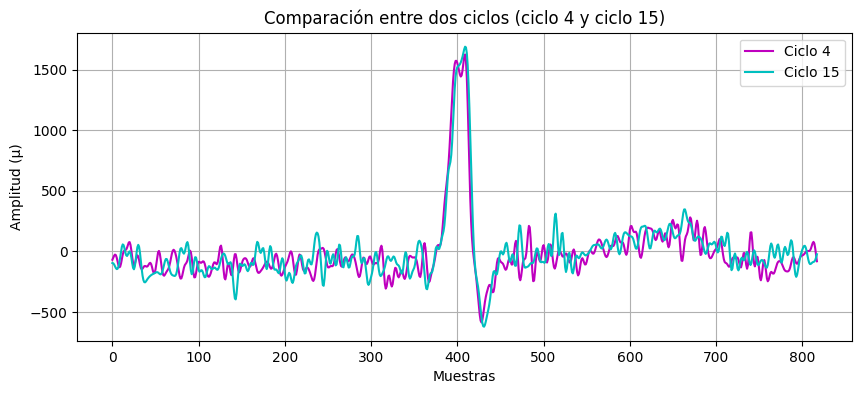


--- Supuestos ---
Normalidad ciclo 4 (p=0.00000000) No normal
Normalidad ciclo 15 (p=0.00000000) No normal
Homocedasticidad (Levene) (p=0.29897919) Varianzas iguales

--- Prueba estadística ---
Prueba U de Mann-Whitney (p=0.00708018)  Diferencias significativas

--- Prueba de Dickey-Fuller para estacionariedad global ---
Estadístico ADF: -24.13410675
Valor p: 0.00000000
 La señal es estacionaria


In [ ]:
# %%
# Esta celda compara los ciclos 4 y 15 de la señal
# y realiza pruebas estadísticas para evaluar su similitud.
# También prueba la estacionariedad de la señal de ECG general.
import numpy as np
import scipy.io
import scipy.signal
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import shapiro, levene, ttest_ind, mannwhitneyu
from statsmodels.tsa.stattools import adfuller

# Cargar datos
mat = scipy.io.loadmat('/content/Biosenales/signals.mat')
ECG = mat['ECG_filtered'].flatten()

# Parámetros
Fm = 1024  # Frecuencia de muestreo
t = np.arange(len(ECG)) / Fm
duracion_ciclo = int(0.8 * Fm)
mitad_ciclo = duracion_ciclo // 2

# Detectar picos R
peaks, _ = scipy.signal.find_peaks(ECG, height=0.8, distance=int(0.6 * Fm))

# Asegurarse que hay suficientes picos
if len(peaks) >= 5:
    # Seleccionar dos picos específicos (no aleatorios)
    peak1, peak2 = peaks[3], peaks[14]  # Por ejemplo, el tercero y el cuarto

    ciclo1 = ECG[max(0, peak1 - mitad_ciclo):peak1 + mitad_ciclo]
    ciclo2 = ECG[max(0, peak2 - mitad_ciclo):peak2 + mitad_ciclo]

    # Graficar los ciclos
    plt.figure(figsize=(10, 4))
    plt.plot(ciclo1, label='Ciclo 4',color='m')
    plt.plot(ciclo2, label='Ciclo 15',color='c')
    plt.title("Comparación entre dos ciclos (ciclo 4 y ciclo 15)")
    plt.xlabel("Muestras")
    plt.ylabel("Amplitud (μ)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Verificación de supuestos
    print("\n--- Supuestos ---")

    # Normalidad
    stat1, p1 = shapiro(ciclo1)
    stat2, p2 = shapiro(ciclo2)
    print(f"Normalidad ciclo 4 (p={p1:.8f}) {' Normal' if p1 > 0.05 else 'No normal'}")
    print(f"Normalidad ciclo 15 (p={p2:.8f}) {' Normal' if p2 > 0.05 else 'No normal'}")

    # Homocedasticidad
    stat_lev, p_lev = levene(ciclo1, ciclo2)
    print(f"Homocedasticidad (Levene) (p={p_lev:.8f}) {'Varianzas iguales' if p_lev > 0.05 else ' Varianzas diferentes'}")

    # Prueba t o prueba U
    print("\n--- Prueba estadística ---")
    if p1 > 0.05 and p2 > 0.05 and p_lev > 0.05:
        stat_t, p_t = ttest_ind(ciclo1, ciclo2)
        print(f"Prueba t (p={p_t:.8f}) {' Diferencia significativa' if p_t < 0.05 else ' No hay diferencia'}")
    else:
        stat_u, p_u = mannwhitneyu(ciclo1, ciclo2)
        print(f"Prueba U de Mann-Whitney (p={p_u:.8f}) {' Diferencias significativas' if p_u < 0.05 else 'No hay diferencia'}")

    # Estacionariedad global con prueba Dickey-Fuller
    print("\n--- Prueba de Dickey-Fuller para estacionariedad global ---")
    adf_stat, p_adf, _, _, _, _ = adfuller(ECG)
    print(f"Estadístico ADF: {adf_stat:.8f}")
    print(f"Valor p: {p_adf:.8f}")
    print(" La señal es estacionaria" if p_adf < 0.05 else "La señal NO es estacionaria")

else:
    print("No hay suficientes picos para realizar el análisis.")